In [ ]:
'''
This script trains the ESMxSXGbg Model, using features from both ESM and HMM/PSSM
'''
# import libraries
import os
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.nn.functional import normalize
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Sampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from torch.nn import CrossEntropyLoss
from torchmetrics import Accuracy
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
from warnings import filterwarnings

filterwarnings("ignore")

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# import utils and features
import parse_files as p
from features import bigram_features0, bigram_features1, bigram_features2, bigram_features3, bigram_features4, bigram_features5

In [ ]:
class SubsetSequentialSampler(Sampler):
    '''This class is used to sample the data sequentially'''
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

In [ ]:
clsfeature = False # true if predicting fold, false if predicting class
rawdata = 'hmm' # use hmm or pssm data
predtype = 'Fold' # predict fold or class
# dataset = 'dd'
# dataset = 'edd'
# dataset = 'tg'
dataset = 'SCOPe'

In [ ]:
# initialize variables
labels = []
hmm = []
seq = []
seqlen = 200
biGram_features0 = []
biGram_features1 = []
biGram_features2 = []
biGram_features3 = []
biGram_features4 = []
biGram_features5 = []


# Load all the filenames of PSSM's
filelist = glob.glob('./data/'+dataset+'/'+rawdata+'/*.txt')

# Read all the labels of the given dataset
if dataset != "SCOPe":
    label_for_seq = p.load_labels('./'+dataset+'_'+predtype+'_labels.txt')

if dataset == "SCOPe":
    label_for_seq = pd.read_csv("./astral_2_08_final.csv") # Make sure all the sequences are in uppercase

# Read all the HMM and PSSM matrices of the given dataset
for i in range(0, len(filelist)):
    seq_hmm, prob_hmm, extras_hmm = p.parse_hmm(filelist[i]) # parse sequence hmm data
    tempseq = seq_hmm.upper() # make sure the sequence is in uppercase
    seq.append(tempseq) # append the sequence to the list
    if dataset != "SCOPe": # append label
        labels.append(label_for_seq[seq_hmm.upper()])
    if dataset == "SCOPe":
        labels.append(label_for_seq.loc[label_for_seq["sequence"] == tempseq]["fold"].values[0])
    # append bigram features
    biGram_features0.append(bigram_features0(prob_hmm))
    biGram_features2.append(bigram_features2(prob_hmm))
    biGram_features3.append(bigram_features3(prob_hmm))
    biGram_features4.append(bigram_features4(prob_hmm))
    biGram_features1.append(bigram_features1(prob_hmm))
    biGram_features5.append(bigram_features5(prob_hmm))

    norm_hmm = prob_hmm + 0.01 # add 0.01 to avoid division by zero
    if(len(norm_hmm) < seqlen): # pad the sequence to make it the same length
        for j in range(seqlen-len(norm_hmm)):
            norm_hmm = np.concatenate((norm_hmm,norm_hmm[0]*0))
    else: # truncate the sequence to make it the same length
        norm_hmm = norm_hmm[:seqlen]
    hmm.append(norm_hmm)

# convert everything to numpy arrays
folds = np.array(labels)
encoder = LabelEncoder()
folds = encoder.fit_transform(folds)
num_classes =  len(np.unique(folds))
foldlabels = pd.get_dummies(folds).values
sequences = [x.upper() for x in seq]
sequences = np.array(sequences)

# convert bigram features to tensors
biGram0 = torch.tensor(biGram_features0, dtype=torch.float32)
biGram1 = torch.tensor(biGram_features1, dtype=torch.float32)
biGram2 = torch.tensor(biGram_features2, dtype=torch.float32)
biGram3 = torch.tensor(biGram_features3, dtype=torch.float32)
biGram4 = torch.tensor(biGram_features4, dtype=torch.float32)
biGram5 = torch.tensor(biGram_features5, dtype=torch.float32)
bigrams = [biGram0, biGram1, biGram2, biGram3, biGram4, biGram5]
# convert hmm features to tensors
hmm = np.array(hmm, dtype=np.float32)
hmm = torch.from_numpy(hmm).float()

In [ ]:
checkpoint = "facebook/esm2_t6_8M_UR50D" # smallest esm model
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # load tokenizer
esm = AutoModel.from_pretrained(checkpoint, add_pooling_layer=False) # load model
loaded_model = torch.load(f"./best_esm/esm_base_{dataset}.pth") # load model weights (make sure this model is trained first by running esm.ipynb)
model_weights = loaded_model["state_dict"] # get model weights
final_weights = {} # initialize final weights
for key, val in model_weights.items(): # get the weights
    if str(key).split(".")[0] != "classifier":
        final_weights[str(key)[4:]] = val
esm.load_state_dict(final_weights) # load the weights

Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
class CNN(nn.Module):   
    '''
    This class defines the CNN model used on bigram features
    '''
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5, stride=5, padding=5),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3),
        ) # define the CNN layers

        self.flatten = nn.Flatten() # flatten the output

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.flatten(x)
        return x

cnn = CNN()

In [ ]:
class ProteinDataset(Dataset):
    '''
    This class defines the dataset used for training
    '''
    def __init__(self, sequences, bigrams, hmm, labels, tokenizer, esm_model, cnn_model, esm_input=True): # initialize the dataset
        self.sequences = sequences
        self.bigrams = bigrams
        self.hmm = hmm
        self.labels = labels
        self.tokenizer = tokenizer
        self.esm_model = esm_model
        self.cnn_model = cnn_model
        self.esm_input = esm_input

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        '''
        fn: __getitem__
        args:
            idx: index of the sequence
        return:
            sample: dictionary containing the input and label
        '''
        sample = {}
        if torch.is_tensor(idx): # convert to list if tensor
            idx = idx.tolist()
        sequence = self.sequences[idx] # get the sequence
        cnn_out = self.cnn_model(self.hmm[idx].unsqueeze(0).unsqueeze(0)) # get the output from the CNN
        # get the bigram features
        bigram0, bigram1, bigram2, bigram3, bigram4, bigram5 = self.bigrams[0][idx], self.bigrams[1][idx], self.bigrams[2][idx], self.bigrams[3][idx], self.bigrams[4][idx], self.bigrams[5][idx]
        label = self.labels[idx] # get the label
        if self.esm_input == True: # if using ESM
            self.esm_model.eval() # set model to eval mode
            esm_hidden_states = self.esm_model(**self.tokenizer(sequence, return_tensors="pt")) # get the hidden states
            esm_out = esm_hidden_states.last_hidden_state[:,0,:] # get the output
            final_input = torch.cat((esm_out, cnn_out, bigram0, bigram1, bigram2, bigram3, bigram4, bigram5), 1) # concatenate the features
        else: # if not using ESM
            final_input = torch.cat((cnn_out, bigram0, bigram1, bigram2, bigram3, bigram4, bigram5), 1) # concatenate the features
        sample["input"] = final_input.squeeze(0) # get the input
        sample["label"] = label # get the label
        return sample # return the sample

In [ ]:
# use gpu if available
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [ ]:
def save(model, optimizer):
    '''
    fn: save model
    args:
        model: model to save
        optimizer: optimizer to save
    return: None
    '''
    filepath = f"./best_multi_feature/model_{dataset}.pth" # save the model
    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    } # get the state
    torch.save(state, filepath) # save the model

class EarlyStopper:
    '''
    this class defines the early stopping mechanism
    '''
    def __init__(self, patience=1, min_delta=0): # initialize the class
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss, model, optimizer): # early stopping mechanism
        if validation_loss < self.min_validation_loss: # if validation loss is less than min validation loss
            self.min_validation_loss = validation_loss # set min validation loss to validation loss
            self.counter = 0 # set counter to 0
            save(model, optimizer) # save the model
        elif validation_loss > (self.min_validation_loss + self.min_delta): # if validation loss is greater than min validation loss + min
            self.counter += 1 # increment counter
            if self.counter >= self.patience: # if counter is greater than patience
                return True # early stop
        return False

In [ ]:
class NeuralNet(nn.Module):
    '''
    This class defines the neural network model
    '''
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim): # initialize the model
        super(NeuralNet, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim1)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="tanh")
        self.layer_2 = nn.Linear(hidden_dim1, hidden_dim2)
        nn.init.kaiming_uniform_(self.layer_2.weight, nonlinearity="tanh")
        self.layer_3 = nn.Linear(hidden_dim2, output_dim)
        self.dropout = nn.Dropout(0.1)
        self.criterion = CrossEntropyLoss()
       
    def forward(self, x, label): # forward pass
        x = nn.functional.tanh(self.layer_1(x))
        x = self.dropout(x)
        x = nn.functional.tanh(self.layer_2(x))
        x = self.dropout(x)
        logits = nn.functional.tanh(self.layer_3(x))
        loss = self.criterion(logits, labels)
        return {"logits": logits, "loss": loss}

In [ ]:
ds = ProteinDataset(sequences, bigrams, hmm, folds, tokenizer, esm, cnn, esm_input=True) # initialize the dataset

In [ ]:
input_dim = ds[0]["input"].shape[0] # get the input dimension
input_dim

2832

In [ ]:
# initialize the batch size, number of epochs, number of classes, and the kfold
batch_size = 4
epochs = 500
num_classes = torch.unique(torch.Tensor(folds)).size()[0]
kf = StratifiedKFold(n_splits=10, shuffle=True)

In [ ]:
# set seed
seed = 420
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

complete_stats = {} # initialize the complete stats

get_acc = Accuracy(task="multiclass", num_classes=num_classes) # get the accuracy
get_acc.to(device)

for i, (train_index, val_index) in enumerate(kf.split(sequences, folds)): # loop through the kfold
    foldname = "Fold " + str(i+1) # get the fold name
    print(foldname + ":")

    train_subsampler = SubsetRandomSampler(train_index) # get the train sampler
    val_subsampler = SubsetSequentialSampler(val_index) # get the validation sampler
    trainloader = DataLoader(ds, batch_size=batch_size, sampler=train_subsampler) # get the train loader
    valloader = DataLoader(ds, batch_size=batch_size, sampler=val_subsampler) # get the validation loader

    model = NeuralNet(input_dim, 512, 128, num_classes) # initialize the model
    model.to(device) # set the model to the device
    optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3) # initialize the optimizer
    early_stopper = EarlyStopper(patience=5, min_delta=0.01) # initialize the early stopper

    training_steps = len(trainloader) * epochs # get the training steps
    # scheduler (no need to use with adam)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=training_steps//10, num_training_steps=training_steps)
    
    split_stats = {"train": {"loss": [], "acc": []}, "val": {"loss": [], "acc": []}} # initialize the split stats
    for epoch in tqdm(range(epochs)): # loop through the epochs
        # initialize train stats
        total_train_loss = 0
        total_train_acc = 0
        avg_train_loss = 0
        avg_train_acc = 0

        model.train() # set model to train mode
        for step, batch in enumerate(trainloader): # loop through the train loader
            inputs = batch["input"].to(device) # get the inputs
            labels = torch.Tensor(batch["label"]).long().to(device) # get the labels
            output = model(inputs, labels) # get the output
            loss = output["loss"] # get the loss
            preds = output["logits"].max(axis=1)[1] # get the predictions
            optimizer.zero_grad() # zero the gradients
            loss.backward() # backpropagate
            optimizer.step() # optimize
            scheduler.step() # step the scheduler
            acc = get_acc(preds, labels) # get the accuracy
            total_train_loss += loss.item() # get the total train loss
            total_train_acc += acc # get the total train accuracy

        # get the average train loss and accuracy
        avg_train_loss = total_train_loss / len(trainloader)
        avg_train_acc = total_train_acc / len(trainloader)
        split_stats["train"]["loss"].append(avg_train_loss)
        split_stats["train"]["acc"].append(avg_train_acc)

        # initialize validation stats
        total_val_acc = 0
        total_val_loss = 0
        avg_val_acc = 0
        avg_val_loss = 0

        model.eval() # set model to eval mode
        with torch.no_grad(): # no need to calculate gradients
            for step, batch in enumerate(valloader): # loop through the validation loader
                inputs = batch["input"].to(device) # get the inputs
                labels = batch["label"].long().to(device) # get the labels
                output = model(inputs, labels) # get the output
                preds = output["logits"].max(axis=1)[1] # get the predictions
                acc = get_acc(preds, labels) # get the accuracy
                total_val_loss += output["loss"].item() # get the total validation loss
                total_val_acc += acc # get the total validation accuracy

        # get the average validation loss and accuracy
        avg_val_loss = total_val_loss / len(valloader)
        avg_val_acc = total_val_acc / len(valloader)
        split_stats["val"]["loss"].append(avg_val_loss)
        split_stats["val"]["acc"].append(avg_val_acc)

        if early_stopper.early_stop(avg_val_loss, model, optimizer):  # check for early stopping
            print(f"\nEarly Stopping!!! Epoch {epoch+1} -> Train Loss: {avg_train_loss} | Train ACC: {avg_train_acc} | Val Loss: {avg_val_loss} | Val Acc: {avg_val_acc}")
            break

        print(f"\nEpoch {epoch+1} -> Train Loss: {avg_train_loss} | Train ACC: {avg_train_acc} | Val Loss: {avg_val_loss} | Val Acc: {avg_val_acc}")

    complete_stats[foldname] = split_stats # get the complete stats

Fold 1:


  0%|          | 1/500 [22:55<190:43:09, 1375.93s/it]


Epoch 1 -> Train Loss: 4.936779224346915 | Train ACC: 0.09032716602087021 | Val Loss: 4.66377137421043 | Val Acc: 0.2292993664741516


  0%|          | 2/500 [46:05<191:27:55, 1384.09s/it]


Epoch 2 -> Train Loss: 4.515132809431421 | Train ACC: 0.3309032618999481 | Val Loss: 4.307953085868982 | Val Acc: 0.4490445852279663


  1%|          | 3/500 [1:10:12<195:01:15, 1412.63s/it]


Epoch 3 -> Train Loss: 4.166265015412191 | Train ACC: 0.5263158082962036 | Val Loss: 3.965807219219815 | Val Acc: 0.6098726391792297


  1%|          | 4/500 [1:34:34<197:19:54, 1432.25s/it]


Epoch 4 -> Train Loss: 3.843814598038729 | Train ACC: 0.6797652840614319 | Val Loss: 3.7150150074320996 | Val Acc: 0.7245222926139832


  1%|          | 5/500 [1:57:07<192:58:54, 1403.50s/it]


Epoch 5 -> Train Loss: 3.6316388460514726 | Train ACC: 0.7780938744544983 | Val Loss: 3.5635076404377153 | Val Acc: 0.8168789744377136


  1%|          | 6/500 [2:19:36<190:05:10, 1385.24s/it]


Epoch 6 -> Train Loss: 3.50594451993831 | Train ACC: 0.8467283248901367 | Val Loss: 3.50738295931725 | Val Acc: 0.8503184914588928


  1%|▏         | 7/500 [2:42:03<187:58:03, 1372.58s/it]


Epoch 7 -> Train Loss: 3.4304738043043046 | Train ACC: 0.87464439868927 | Val Loss: 3.4197946764101648 | Val Acc: 0.8837579488754272


  2%|▏         | 8/500 [3:04:45<187:07:45, 1369.24s/it]


Epoch 8 -> Train Loss: 3.3897265521425273 | Train ACC: 0.8975817561149597 | Val Loss: 3.3975171177250565 | Val Acc: 0.8821656107902527


  2%|▏         | 9/500 [3:27:10<185:43:00, 1361.67s/it]


Epoch 9 -> Train Loss: 3.358680253008521 | Train ACC: 0.9144736528396606 | Val Loss: 3.374547665286216 | Val Acc: 0.8917197585105896


  2%|▏         | 10/500 [3:49:36<184:41:18, 1356.89s/it]


Epoch 10 -> Train Loss: 3.3445224894229244 | Train ACC: 0.9190967082977295 | Val Loss: 3.361564734938798 | Val Acc: 0.9044586420059204


  2%|▏         | 11/500 [4:12:13<184:19:00, 1356.93s/it]


Epoch 11 -> Train Loss: 3.33747675001706 | Train ACC: 0.9194523096084595 | Val Loss: 3.3596162917507684 | Val Acc: 0.8933120965957642


  2%|▏         | 12/500 [4:34:45<183:42:44, 1355.26s/it]


Epoch 12 -> Train Loss: 3.3403493513592957 | Train ACC: 0.9135846495628357 | Val Loss: 3.368585270681199 | Val Acc: 0.9044586420059204


  3%|▎         | 13/500 [4:57:11<182:56:58, 1352.40s/it]


Epoch 13 -> Train Loss: 3.3164527470492366 | Train ACC: 0.9258534908294678 | Val Loss: 3.3342866244589446 | Val Acc: 0.8980891704559326


  3%|▎         | 14/500 [5:19:39<182:25:43, 1351.32s/it]


Epoch 14 -> Train Loss: 3.343360118302987 | Train ACC: 0.9096727967262268 | Val Loss: 3.347761123803011 | Val Acc: 0.912420392036438


  3%|▎         | 15/500 [5:42:17<182:17:22, 1353.08s/it]


Epoch 15 -> Train Loss: 3.3353005203380013 | Train ACC: 0.9132289886474609 | Val Loss: 3.335168437593302 | Val Acc: 0.912420392036438


  3%|▎         | 16/500 [6:04:41<181:34:27, 1350.55s/it]


Epoch 16 -> Train Loss: 3.3238682731625704 | Train ACC: 0.9162517786026001 | Val Loss: 3.3778277855769843 | Val Acc: 0.8630573153495789


  3%|▎         | 17/500 [6:27:09<181:05:46, 1349.78s/it]


Epoch 17 -> Train Loss: 3.334214154890557 | Train ACC: 0.9103840589523315 | Val Loss: 3.4441235612152488 | Val Acc: 0.7627388834953308


  4%|▎         | 18/500 [6:49:39<180:43:52, 1349.86s/it]


Epoch 18 -> Train Loss: 3.343346812647064 | Train ACC: 0.9075391292572021 | Val Loss: 3.3381214551864917 | Val Acc: 0.912420392036438


  4%|▍         | 19/500 [7:12:03<180:06:08, 1347.96s/it]


Epoch 19 -> Train Loss: 3.339627055151873 | Train ACC: 0.9061166048049927 | Val Loss: 3.3761420584028694 | Val Acc: 0.8837579488754272


  4%|▍         | 19/500 [7:34:41<191:50:44, 1435.85s/it]



Early Stopping!!! Epoch 20 -> Train Loss: 3.339055302472067 | Train ACC: 0.8974039554595947 | Val Loss: 3.4161598393871526 | Val Acc: 0.8423566818237305
Fold 2:


  0%|          | 1/500 [22:33<187:32:50, 1353.05s/it]


Epoch 1 -> Train Loss: 4.94579320781431 | Train ACC: 0.103662870824337 | Val Loss: 4.669884277756807 | Val Acc: 0.2229299396276474


  0%|          | 2/500 [45:02<186:53:22, 1351.01s/it]


Epoch 2 -> Train Loss: 4.510094448478937 | Train ACC: 0.3362375497817993 | Val Loss: 4.299609380163205 | Val Acc: 0.5477707386016846


  1%|          | 3/500 [1:07:34<186:34:59, 1351.51s/it]


Epoch 3 -> Train Loss: 4.147259278792576 | Train ACC: 0.5407183170318604 | Val Loss: 3.9661542199979163 | Val Acc: 0.6831210255622864


  1%|          | 4/500 [1:30:07<186:15:24, 1351.86s/it]


Epoch 4 -> Train Loss: 3.830170437587613 | Train ACC: 0.7158606052398682 | Val Loss: 3.70438125634649 | Val Acc: 0.8041401505470276


  1%|          | 5/500 [1:52:36<185:44:54, 1350.90s/it]


Epoch 5 -> Train Loss: 3.621211981366403 | Train ACC: 0.8145447969436646 | Val Loss: 3.5573966427213826 | Val Acc: 0.8423566818237305


  1%|          | 6/500 [2:15:14<185:42:34, 1353.35s/it]


Epoch 6 -> Train Loss: 3.4995252258577523 | Train ACC: 0.8655760884284973 | Val Loss: 3.4739935398101807 | Val Acc: 0.8853503465652466


  1%|▏         | 7/500 [2:37:48<185:21:17, 1353.50s/it]


Epoch 7 -> Train Loss: 3.42538975872322 | Train ACC: 0.8940256237983704 | Val Loss: 3.435071132744953 | Val Acc: 0.8710191249847412


  2%|▏         | 8/500 [3:00:15<184:42:20, 1351.50s/it]


Epoch 8 -> Train Loss: 3.382813030082844 | Train ACC: 0.9087837934494019 | Val Loss: 3.3978677600812 | Val Acc: 0.8933120965957642


  2%|▏         | 9/500 [3:22:46<184:19:21, 1351.45s/it]


Epoch 9 -> Train Loss: 3.3606874737597123 | Train ACC: 0.9110953211784363 | Val Loss: 3.3819138851894697 | Val Acc: 0.8933120965957642


  2%|▏         | 10/500 [3:45:14<183:47:52, 1350.35s/it]


Epoch 10 -> Train Loss: 3.3437194435898303 | Train ACC: 0.9201635718345642 | Val Loss: 3.381659885880294 | Val Acc: 0.8726114630699158


  2%|▏         | 11/500 [4:07:39<183:11:22, 1348.63s/it]


Epoch 11 -> Train Loss: 3.3420059765724845 | Train ACC: 0.9158961772918701 | Val Loss: 3.3344837039898914 | Val Acc: 0.9235668778419495


  2%|▏         | 12/500 [4:30:20<183:20:14, 1352.49s/it]


Epoch 12 -> Train Loss: 3.3302992923161385 | Train ACC: 0.9224750995635986 | Val Loss: 3.3768562769434256 | Val Acc: 0.9012739062309265


  3%|▎         | 13/500 [4:52:53<182:58:17, 1352.56s/it]


Epoch 13 -> Train Loss: 3.3327840592070967 | Train ACC: 0.9171408414840698 | Val Loss: 3.3789095833043383 | Val Acc: 0.8885350227355957


  3%|▎         | 14/500 [5:15:28<182:40:44, 1353.18s/it]


Epoch 14 -> Train Loss: 3.331467426009741 | Train ACC: 0.9153627157211304 | Val Loss: 3.331756230372532 | Val Acc: 0.9251592755317688


  3%|▎         | 15/500 [5:38:04<182:26:29, 1354.21s/it]


Epoch 15 -> Train Loss: 3.328488499646845 | Train ACC: 0.9118065237998962 | Val Loss: 3.322727136551195 | Val Acc: 0.9044586420059204


  3%|▎         | 16/500 [6:00:39<182:04:33, 1354.28s/it]


Epoch 16 -> Train Loss: 3.3358802112034 | Train ACC: 0.9071834683418274 | Val Loss: 3.333293665746215 | Val Acc: 0.9251592755317688


  3%|▎         | 17/500 [6:23:09<181:32:02, 1353.05s/it]


Epoch 17 -> Train Loss: 3.3345277460337024 | Train ACC: 0.9100284576416016 | Val Loss: 3.3456434990949693 | Val Acc: 0.9283439517021179


  4%|▎         | 18/500 [6:45:41<181:08:04, 1352.87s/it]


Epoch 18 -> Train Loss: 3.354208396474803 | Train ACC: 0.8929587602615356 | Val Loss: 3.336330866358083 | Val Acc: 0.9283439517021179


  4%|▍         | 19/500 [7:08:16<180:49:07, 1353.32s/it]


Epoch 19 -> Train Loss: 3.345865181126601 | Train ACC: 0.8933143615722656 | Val Loss: 3.3500191876842718 | Val Acc: 0.9076433181762695


  4%|▍         | 19/500 [7:30:50<190:13:23, 1423.71s/it]



Early Stopping!!! Epoch 20 -> Train Loss: 3.3493910576846146 | Train ACC: 0.8947368264198303 | Val Loss: 3.3654203870493893 | Val Acc: 0.8980891704559326
Fold 3:


  0%|          | 1/500 [22:27<186:47:25, 1347.59s/it]


Epoch 1 -> Train Loss: 4.941071265452617 | Train ACC: 0.10810810327529907 | Val Loss: 4.668871879577637 | Val Acc: 0.2531847059726715


  0%|          | 2/500 [45:01<186:57:26, 1351.50s/it]


Epoch 2 -> Train Loss: 4.509283076309377 | Train ACC: 0.3709103763103485 | Val Loss: 4.298487897131853 | Val Acc: 0.48407644033432007


  1%|          | 3/500 [1:07:43<187:12:40, 1356.06s/it]


Epoch 3 -> Train Loss: 4.141083159792644 | Train ACC: 0.5414295792579651 | Val Loss: 3.9515087148945804 | Val Acc: 0.6910828351974487


  1%|          | 4/500 [1:30:11<186:26:02, 1353.15s/it]


Epoch 4 -> Train Loss: 3.829642528490525 | Train ACC: 0.6660739779472351 | Val Loss: 3.691290718734644 | Val Acc: 0.727707028388977


  1%|          | 5/500 [1:52:52<186:25:18, 1355.79s/it]


Epoch 5 -> Train Loss: 3.6266530160374866 | Train ACC: 0.7638691067695618 | Val Loss: 3.552550384193469 | Val Acc: 0.8121019005775452


  1%|          | 6/500 [2:15:23<185:50:37, 1354.33s/it]


Epoch 6 -> Train Loss: 3.503875622369487 | Train ACC: 0.8358819484710693 | Val Loss: 3.4522634190358934 | Val Acc: 0.8455414175987244


  1%|▏         | 7/500 [2:37:55<185:19:58, 1353.34s/it]


Epoch 7 -> Train Loss: 3.4296682845817013 | Train ACC: 0.8801564574241638 | Val Loss: 3.446473352468697 | Val Acc: 0.8630573153495789


  2%|▏         | 8/500 [3:00:34<185:12:01, 1355.12s/it]


Epoch 8 -> Train Loss: 3.3917965370085974 | Train ACC: 0.8913584351539612 | Val Loss: 3.380074138094665 | Val Acc: 0.8757961988449097


  2%|▏         | 9/500 [3:23:06<184:43:06, 1354.35s/it]


Epoch 9 -> Train Loss: 3.3616547772758887 | Train ACC: 0.9066500663757324 | Val Loss: 3.3617183205428396 | Val Acc: 0.8662420511245728


  2%|▏         | 10/500 [3:45:38<184:12:49, 1353.41s/it]


Epoch 10 -> Train Loss: 3.350146763016116 | Train ACC: 0.9105618596076965 | Val Loss: 3.3642372189054064 | Val Acc: 0.8949044942855835


  2%|▏         | 11/500 [4:08:21<184:13:52, 1356.30s/it]


Epoch 11 -> Train Loss: 3.339816826336075 | Train ACC: 0.9185633063316345 | Val Loss: 3.3467878323451727 | Val Acc: 0.8773885369300842


  2%|▏         | 12/500 [4:30:56<183:49:36, 1356.10s/it]


Epoch 12 -> Train Loss: 3.332877363622782 | Train ACC: 0.9230085015296936 | Val Loss: 3.3522721156952486 | Val Acc: 0.912420392036438


  3%|▎         | 13/500 [4:53:24<183:06:43, 1353.60s/it]


Epoch 13 -> Train Loss: 3.33021218678351 | Train ACC: 0.9185633063316345 | Val Loss: 3.4040769953636607 | Val Acc: 0.8073248267173767


  3%|▎         | 14/500 [5:15:54<182:35:32, 1352.54s/it]


Epoch 14 -> Train Loss: 3.3358991666674442 | Train ACC: 0.9093171954154968 | Val Loss: 3.3247027290854483 | Val Acc: 0.906050980091095


  3%|▎         | 15/500 [5:38:43<182:52:46, 1357.46s/it]


Epoch 15 -> Train Loss: 3.33433893785029 | Train ACC: 0.9109174609184265 | Val Loss: 3.3374958767253124 | Val Acc: 0.906050980091095


  3%|▎         | 16/500 [6:01:43<183:25:44, 1364.35s/it]


Epoch 16 -> Train Loss: 3.3358133397095573 | Train ACC: 0.9153627157211304 | Val Loss: 3.3467362473724753 | Val Acc: 0.9076433181762695


  3%|▎         | 17/500 [6:24:17<182:37:36, 1361.19s/it]


Epoch 17 -> Train Loss: 3.3423688876340605 | Train ACC: 0.9071834683418274 | Val Loss: 3.363225689359531 | Val Acc: 0.8646497130393982


  4%|▎         | 18/500 [6:46:52<181:59:58, 1359.33s/it]


Epoch 18 -> Train Loss: 3.3479853537818616 | Train ACC: 0.9020270109176636 | Val Loss: 3.3435825268933725 | Val Acc: 0.8885350227355957


  4%|▍         | 19/500 [7:09:26<181:23:11, 1357.57s/it]


Epoch 19 -> Train Loss: 3.3450622845170845 | Train ACC: 0.9006045460700989 | Val Loss: 3.332960616251466 | Val Acc: 0.8773885369300842


  4%|▍         | 19/500 [7:32:00<190:43:08, 1427.42s/it]



Early Stopping!!! Epoch 20 -> Train Loss: 3.34269506527723 | Train ACC: 0.8993598818778992 | Val Loss: 3.34120952247814 | Val Acc: 0.912420392036438
Fold 4:


  0%|          | 1/500 [22:34<187:41:02, 1354.03s/it]


Epoch 1 -> Train Loss: 4.931128245837997 | Train ACC: 0.09210526198148727 | Val Loss: 4.6514687629262355 | Val Acc: 0.2675159275531769


  0%|          | 2/500 [45:08<187:21:48, 1354.44s/it]


Epoch 2 -> Train Loss: 4.494689577504208 | Train ACC: 0.37428876757621765 | Val Loss: 4.291255586466212 | Val Acc: 0.5191082954406738


  1%|          | 3/500 [1:07:49<187:22:15, 1357.21s/it]


Epoch 3 -> Train Loss: 4.142123305780619 | Train ACC: 0.5593883395195007 | Val Loss: 3.945044244170948 | Val Acc: 0.6831210255622864


  1%|          | 4/500 [1:30:34<187:26:53, 1360.51s/it]


Epoch 4 -> Train Loss: 3.8310105280041866 | Train ACC: 0.699857771396637 | Val Loss: 3.700542791633849 | Val Acc: 0.8041401505470276


  1%|          | 5/500 [1:53:13<186:57:33, 1359.70s/it]


Epoch 5 -> Train Loss: 3.6229783974874072 | Train ACC: 0.7976529002189636 | Val Loss: 3.5807433842094083 | Val Acc: 0.7945860028266907


  1%|          | 6/500 [2:15:53<186:37:23, 1360.01s/it]


Epoch 6 -> Train Loss: 3.502365957622338 | Train ACC: 0.8479729890823364 | Val Loss: 3.4591922091830307 | Val Acc: 0.8710191249847412


  1%|▏         | 7/500 [2:38:36<186:22:25, 1360.94s/it]


Epoch 7 -> Train Loss: 3.430846818480349 | Train ACC: 0.8826457858085632 | Val Loss: 3.4131356956093173 | Val Acc: 0.8821656107902527


  2%|▏         | 8/500 [3:01:10<185:40:42, 1358.62s/it]


Epoch 8 -> Train Loss: 3.386398530956013 | Train ACC: 0.9002489447593689 | Val Loss: 3.3951770439269437 | Val Acc: 0.9140127301216125


  2%|▏         | 9/500 [3:23:50<185:22:29, 1359.16s/it]


Epoch 9 -> Train Loss: 3.359984609005631 | Train ACC: 0.912339985370636 | Val Loss: 3.360294255481404 | Val Acc: 0.8980891704559326


  2%|▏         | 10/500 [3:46:37<185:19:36, 1361.58s/it]


Epoch 10 -> Train Loss: 3.3536858743488533 | Train ACC: 0.9107396602630615 | Val Loss: 3.3400289890872443 | Val Acc: 0.9076433181762695


  2%|▏         | 11/500 [4:09:14<184:45:10, 1360.14s/it]


Epoch 11 -> Train Loss: 3.3361288892425818 | Train ACC: 0.9144736528396606 | Val Loss: 3.348089382147333 | Val Acc: 0.9028662443161011


  2%|▏         | 12/500 [4:32:07<184:53:43, 1363.98s/it]


Epoch 12 -> Train Loss: 3.3341899988152734 | Train ACC: 0.9171408414840698 | Val Loss: 3.3328480310500805 | Val Acc: 0.9156051278114319


  3%|▎         | 13/500 [4:54:43<184:12:41, 1361.73s/it]


Epoch 13 -> Train Loss: 3.3332825069915857 | Train ACC: 0.9109174609184265 | Val Loss: 3.3361381816256577 | Val Acc: 0.8949044942855835


  3%|▎         | 14/500 [5:17:21<183:40:05, 1360.51s/it]


Epoch 14 -> Train Loss: 3.3325638123291146 | Train ACC: 0.912339985370636 | Val Loss: 3.33526808137347 | Val Acc: 0.912420392036438


  3%|▎         | 15/500 [5:39:59<183:10:19, 1359.63s/it]


Epoch 15 -> Train Loss: 3.3344048047981425 | Train ACC: 0.9091393947601318 | Val Loss: 3.4116202403026024 | Val Acc: 0.8391720056533813


  3%|▎         | 16/500 [6:02:42<182:57:35, 1360.86s/it]


Epoch 16 -> Train Loss: 3.3349497976208142 | Train ACC: 0.9073613286018372 | Val Loss: 3.3272443865514862 | Val Acc: 0.9140127301216125


  3%|▎         | 17/500 [6:25:22<182:31:33, 1360.44s/it]


Epoch 17 -> Train Loss: 3.3394369424491654 | Train ACC: 0.9030938744544983 | Val Loss: 3.3335859304780415 | Val Acc: 0.906050980091095


  4%|▎         | 18/500 [6:47:59<182:01:29, 1359.52s/it]


Epoch 18 -> Train Loss: 3.33284038602034 | Train ACC: 0.9068278670310974 | Val Loss: 3.3331732916983827 | Val Acc: 0.9171974658966064


  4%|▍         | 19/500 [7:10:41<181:45:24, 1360.34s/it]


Epoch 19 -> Train Loss: 3.3618256377631197 | Train ACC: 0.8808677196502686 | Val Loss: 3.38975739175347 | Val Acc: 0.8439490795135498


  4%|▍         | 20/500 [7:33:17<181:11:43, 1358.96s/it]


Epoch 20 -> Train Loss: 3.3444129762744494 | Train ACC: 0.8986486196517944 | Val Loss: 3.364400816571181 | Val Acc: 0.8710191249847412


  4%|▍         | 21/500 [7:55:54<180:44:02, 1358.34s/it]


Epoch 21 -> Train Loss: 3.348973666451564 | Train ACC: 0.8867354393005371 | Val Loss: 3.3930354786526626 | Val Acc: 0.8614649772644043


  4%|▍         | 22/500 [8:18:30<180:15:04, 1357.54s/it]


Epoch 22 -> Train Loss: 3.368327011254909 | Train ACC: 0.8714438080787659 | Val Loss: 3.3891397023656564 | Val Acc: 0.8885350227355957


  5%|▍         | 23/500 [8:41:19<180:19:56, 1361.00s/it]


Epoch 23 -> Train Loss: 3.3450183118898873 | Train ACC: 0.8906472325325012 | Val Loss: 3.334448563824793 | Val Acc: 0.899681568145752


  5%|▍         | 23/500 [9:03:59<188:01:53, 1419.11s/it]



Early Stopping!!! Epoch 24 -> Train Loss: 3.3602405727163998 | Train ACC: 0.8782005310058594 | Val Loss: 3.3465883807771526 | Val Acc: 0.8694267868995667
Fold 5:


  0%|          | 1/500 [22:35<187:51:30, 1355.29s/it]


Epoch 1 -> Train Loss: 4.957423041928374 | Train ACC: 0.09157183766365051 | Val Loss: 4.6826642394825155 | Val Acc: 0.24522292613983154


  0%|          | 2/500 [45:11<187:35:28, 1356.08s/it]


Epoch 2 -> Train Loss: 4.5151003670387215 | Train ACC: 0.3403271734714508 | Val Loss: 4.288158003691655 | Val Acc: 0.4761146605014801


  1%|          | 3/500 [1:07:46<187:07:04, 1355.38s/it]


Epoch 3 -> Train Loss: 4.1333785572567505 | Train ACC: 0.5391180515289307 | Val Loss: 3.9449992559518026 | Val Acc: 0.587579607963562


  1%|          | 4/500 [1:30:23<186:48:49, 1355.91s/it]


Epoch 4 -> Train Loss: 3.82211587744451 | Train ACC: 0.6762090921401978 | Val Loss: 3.680981959506964 | Val Acc: 0.7786624431610107


  1%|          | 5/500 [1:53:09<186:57:37, 1359.71s/it]


Epoch 5 -> Train Loss: 3.622631759935219 | Train ACC: 0.7836059927940369 | Val Loss: 3.539510131641558 | Val Acc: 0.8232484459877014


  1%|          | 6/500 [2:15:45<186:23:35, 1358.33s/it]


Epoch 6 -> Train Loss: 3.5018874103280253 | Train ACC: 0.8467283248901367 | Val Loss: 3.4583303077965026 | Val Acc: 0.8694267868995667


  1%|▏         | 7/500 [2:38:20<185:52:47, 1357.34s/it]


Epoch 7 -> Train Loss: 3.4355156101169833 | Train ACC: 0.8830013871192932 | Val Loss: 3.4166848143194892 | Val Acc: 0.8885350227355957


  2%|▏         | 8/500 [3:00:55<185:25:04, 1356.72s/it]


Epoch 8 -> Train Loss: 3.390496699433578 | Train ACC: 0.903805136680603 | Val Loss: 3.3801479734432927 | Val Acc: 0.8917197585105896


  2%|▏         | 9/500 [3:23:31<184:58:40, 1356.25s/it]


Epoch 9 -> Train Loss: 3.362053311227226 | Train ACC: 0.9146515130996704 | Val Loss: 3.353094441116236 | Val Acc: 0.9267516136169434


  2%|▏         | 10/500 [3:46:09<184:42:17, 1357.02s/it]


Epoch 10 -> Train Loss: 3.3464342192938794 | Train ACC: 0.9212304353713989 | Val Loss: 3.3771999793447507 | Val Acc: 0.9012739062309265


  2%|▏         | 11/500 [4:08:54<184:39:05, 1359.40s/it]


Epoch 11 -> Train Loss: 3.34466836801803 | Train ACC: 0.912339985370636 | Val Loss: 3.3431009638840985 | Val Acc: 0.906050980091095


  2%|▏         | 12/500 [4:31:36<184:21:44, 1360.05s/it]


Epoch 12 -> Train Loss: 3.329543518986166 | Train ACC: 0.925142228603363 | Val Loss: 3.3363900032772382 | Val Acc: 0.918789803981781


  3%|▎         | 13/500 [4:54:05<183:32:16, 1356.75s/it]


Epoch 13 -> Train Loss: 3.3340810947703092 | Train ACC: 0.9214082360267639 | Val Loss: 3.3244118857535585 | Val Acc: 0.912420392036438


  3%|▎         | 14/500 [5:17:06<184:08:57, 1364.07s/it]


Epoch 14 -> Train Loss: 3.330924647291897 | Train ACC: 0.9270981550216675 | Val Loss: 3.328780801432907 | Val Acc: 0.9219745397567749


  3%|▎         | 15/500 [5:39:46<183:36:57, 1362.92s/it]


Epoch 15 -> Train Loss: 3.340496880231507 | Train ACC: 0.9066500663757324 | Val Loss: 3.328544601513322 | Val Acc: 0.9108280539512634


  3%|▎         | 16/500 [6:02:25<183:03:12, 1361.56s/it]


Epoch 16 -> Train Loss: 3.337505473351241 | Train ACC: 0.9093171954154968 | Val Loss: 3.353872593800733 | Val Acc: 0.9028662443161011


  3%|▎         | 17/500 [6:25:19<183:12:00, 1365.47s/it]


Epoch 17 -> Train Loss: 3.340888478169231 | Train ACC: 0.9087837934494019 | Val Loss: 3.350820163253007 | Val Acc: 0.906050980091095


  4%|▎         | 18/500 [6:48:05<182:50:39, 1365.64s/it]


Epoch 18 -> Train Loss: 3.341865092219194 | Train ACC: 0.9086059927940369 | Val Loss: 3.339514024698051 | Val Acc: 0.912420392036438


  4%|▍         | 19/500 [7:10:39<181:59:47, 1362.14s/it]


Epoch 19 -> Train Loss: 3.3507461366409257 | Train ACC: 0.9004267454147339 | Val Loss: 3.33001929028019 | Val Acc: 0.9108280539512634


  4%|▍         | 20/500 [7:33:16<181:25:19, 1360.67s/it]


Epoch 20 -> Train Loss: 3.3441585897551493 | Train ACC: 0.8977596163749695 | Val Loss: 3.360928495978094 | Val Acc: 0.8789808750152588


  4%|▍         | 21/500 [7:55:51<180:47:22, 1358.75s/it]


Epoch 21 -> Train Loss: 3.3587687398766723 | Train ACC: 0.887802243232727 | Val Loss: 3.325129331297176 | Val Acc: 0.9219745397567749


  4%|▍         | 21/500 [8:18:23<189:28:13, 1423.99s/it]



Early Stopping!!! Epoch 22 -> Train Loss: 3.350155939079111 | Train ACC: 0.8984708189964294 | Val Loss: 3.3412523284839217 | Val Acc: 0.8789808750152588
Fold 6:


  0%|          | 1/500 [22:47<189:32:08, 1367.39s/it]


Epoch 1 -> Train Loss: 4.970155619286202 | Train ACC: 0.09815078228712082 | Val Loss: 4.683619657139869 | Val Acc: 0.3105095624923706


  0%|          | 2/500 [45:14<187:30:10, 1355.44s/it]


Epoch 2 -> Train Loss: 4.5118501218589575 | Train ACC: 0.4004267454147339 | Val Loss: 4.312418936164516 | Val Acc: 0.5541401505470276


  1%|          | 3/500 [1:07:42<186:38:39, 1351.95s/it]


Epoch 3 -> Train Loss: 4.148207058268963 | Train ACC: 0.5899715423583984 | Val Loss: 3.945956231682164 | Val Acc: 0.6767516136169434


  1%|          | 4/500 [1:30:11<186:06:24, 1350.77s/it]


Epoch 4 -> Train Loss: 3.8321263591731087 | Train ACC: 0.7103484869003296 | Val Loss: 3.6981007642806714 | Val Acc: 0.7229299545288086


  1%|          | 5/500 [1:52:40<185:39:24, 1350.23s/it]


Epoch 5 -> Train Loss: 3.625855569310412 | Train ACC: 0.7962304353713989 | Val Loss: 3.5520733116538663 | Val Acc: 0.831210196018219


  1%|          | 6/500 [2:15:10<185:15:51, 1350.10s/it]


Epoch 6 -> Train Loss: 3.5031257542234395 | Train ACC: 0.8424608707427979 | Val Loss: 3.4615475402516163 | Val Acc: 0.8471337556838989


  1%|▏         | 7/500 [2:37:40<184:53:22, 1350.11s/it]


Epoch 7 -> Train Loss: 3.4296157051455416 | Train ACC: 0.8838904500007629 | Val Loss: 3.409015500621431 | Val Acc: 0.8742038607597351


  2%|▏         | 8/500 [3:00:33<185:29:59, 1357.32s/it]


Epoch 8 -> Train Loss: 3.3918220869677502 | Train ACC: 0.8915362358093262 | Val Loss: 3.387137053119149 | Val Acc: 0.906050980091095


  2%|▏         | 9/500 [3:23:37<186:17:13, 1365.85s/it]


Epoch 9 -> Train Loss: 3.362653766722971 | Train ACC: 0.9061166048049927 | Val Loss: 3.363243397633741 | Val Acc: 0.9171974658966064


  2%|▏         | 10/500 [3:47:41<189:10:17, 1389.83s/it]


Epoch 10 -> Train Loss: 3.352567776338135 | Train ACC: 0.9062944650650024 | Val Loss: 3.3599782475999964 | Val Acc: 0.9108280539512634


  2%|▏         | 11/500 [4:10:19<187:27:16, 1380.03s/it]


Epoch 11 -> Train Loss: 3.3434822891718294 | Train ACC: 0.9183855056762695 | Val Loss: 3.318158310689744 | Val Acc: 0.9219745397567749


  2%|▏         | 12/500 [4:32:56<186:07:57, 1373.11s/it]


Epoch 12 -> Train Loss: 3.333871918416464 | Train ACC: 0.9155405163764954 | Val Loss: 3.3529884147036606 | Val Acc: 0.9203822016716003


  3%|▎         | 13/500 [4:55:33<185:05:46, 1368.27s/it]


Epoch 13 -> Train Loss: 3.3291888128473275 | Train ACC: 0.9185633063316345 | Val Loss: 3.370891648492995 | Val Acc: 0.824840784072876


  3%|▎         | 14/500 [5:18:15<184:27:03, 1366.30s/it]


Epoch 14 -> Train Loss: 3.339816082422628 | Train ACC: 0.9112731218338013 | Val Loss: 3.329187584530776 | Val Acc: 0.9299362897872925


  3%|▎         | 15/500 [5:42:14<187:00:59, 1388.16s/it]


Epoch 15 -> Train Loss: 3.330428758691758 | Train ACC: 0.9151849150657654 | Val Loss: 3.335496519781222 | Val Acc: 0.912420392036438


  3%|▎         | 15/500 [6:05:45<197:05:57, 1463.00s/it]



Early Stopping!!! Epoch 16 -> Train Loss: 3.331356678714454 | Train ACC: 0.9107396602630615 | Val Loss: 3.344783119335296 | Val Acc: 0.9044586420059204
Fold 7:


  0%|          | 1/500 [23:48<198:04:16, 1428.97s/it]


Epoch 1 -> Train Loss: 4.942761763400408 | Train ACC: 0.09921763837337494 | Val Loss: 4.681073759771456 | Val Acc: 0.2531847059726715


  0%|          | 2/500 [47:57<199:16:57, 1440.60s/it]


Epoch 2 -> Train Loss: 4.522939157350304 | Train ACC: 0.337482213973999 | Val Loss: 4.308561583233487 | Val Acc: 0.4347133934497833


  1%|          | 3/500 [1:11:19<196:24:43, 1422.70s/it]


Epoch 3 -> Train Loss: 4.151328849588994 | Train ACC: 0.5476529002189636 | Val Loss: 3.9474369613987625 | Val Acc: 0.6385350227355957


  1%|          | 4/500 [1:34:08<193:06:29, 1401.59s/it]


Epoch 4 -> Train Loss: 3.8337412155200203 | Train ACC: 0.7048364281654358 | Val Loss: 3.7010663466848386 | Val Acc: 0.7707006335258484


  1%|          | 5/500 [1:56:47<190:37:16, 1386.34s/it]


Epoch 5 -> Train Loss: 3.6255696077604553 | Train ACC: 0.7960526347160339 | Val Loss: 3.5409543195347877 | Val Acc: 0.8359872698783875


  1%|          | 6/500 [2:19:35<189:23:35, 1380.19s/it]


Epoch 6 -> Train Loss: 3.500860606284433 | Train ACC: 0.866465151309967 | Val Loss: 3.450582921884622 | Val Acc: 0.8773885369300842


  1%|▏         | 7/500 [2:42:14<188:02:06, 1373.08s/it]


Epoch 7 -> Train Loss: 3.430544329571351 | Train ACC: 0.8874466419219971 | Val Loss: 3.4128899285747747 | Val Acc: 0.8853503465652466


  2%|▏         | 8/500 [3:04:54<187:05:57, 1369.02s/it]


Epoch 8 -> Train Loss: 3.3877379321102397 | Train ACC: 0.9087837934494019 | Val Loss: 3.364798981672639 | Val Acc: 0.9283439517021179


  2%|▏         | 9/500 [3:27:37<186:26:55, 1367.04s/it]


Epoch 9 -> Train Loss: 3.3619999415843957 | Train ACC: 0.9153627157211304 | Val Loss: 3.3580917689450986 | Val Acc: 0.9171974658966064


  2%|▏         | 10/500 [3:50:16<185:43:06, 1364.46s/it]


Epoch 10 -> Train Loss: 3.3479059992270654 | Train ACC: 0.9201635718345642 | Val Loss: 3.369701156191006 | Val Acc: 0.9108280539512634


  2%|▏         | 11/500 [4:12:52<185:00:20, 1362.00s/it]


Epoch 11 -> Train Loss: 3.3328316861162146 | Train ACC: 0.9265646934509277 | Val Loss: 3.333680392830235 | Val Acc: 0.9235668778419495


  2%|▏         | 12/500 [4:35:31<184:30:40, 1361.15s/it]


Epoch 12 -> Train Loss: 3.3373206136575972 | Train ACC: 0.9180298447608948 | Val Loss: 3.35204642441622 | Val Acc: 0.906050980091095


  3%|▎         | 13/500 [4:58:10<184:01:38, 1360.37s/it]


Epoch 13 -> Train Loss: 3.3338340948180827 | Train ACC: 0.9190967082977295 | Val Loss: 3.3291484125100883 | Val Acc: 0.9251592755317688


  3%|▎         | 14/500 [5:20:50<183:39:25, 1360.42s/it]


Epoch 14 -> Train Loss: 3.3309588969856034 | Train ACC: 0.9171408414840698 | Val Loss: 3.3305648253981475 | Val Acc: 0.8964968323707581


  3%|▎         | 15/500 [5:43:31<183:18:08, 1360.59s/it]


Epoch 15 -> Train Loss: 3.3470986594855363 | Train ACC: 0.9071834683418274 | Val Loss: 3.369617453046665 | Val Acc: 0.8789808750152588


  3%|▎         | 16/500 [6:06:09<182:49:08, 1359.81s/it]


Epoch 16 -> Train Loss: 3.3372828243128096 | Train ACC: 0.9055832028388977 | Val Loss: 3.306804904512539 | Val Acc: 0.9235668778419495


  3%|▎         | 17/500 [6:28:49<182:25:13, 1359.66s/it]


Epoch 17 -> Train Loss: 3.3370367939746908 | Train ACC: 0.9036272764205933 | Val Loss: 3.3320953982650856 | Val Acc: 0.9203822016716003


  4%|▎         | 18/500 [6:51:30<182:05:59, 1360.08s/it]


Epoch 18 -> Train Loss: 3.3330079159390706 | Train ACC: 0.9077169299125671 | Val Loss: 3.352048031084097 | Val Acc: 0.8487261533737183


  4%|▍         | 19/500 [7:14:10<181:44:13, 1360.19s/it]


Epoch 19 -> Train Loss: 3.3542443281556262 | Train ACC: 0.8940256237983704 | Val Loss: 3.341286829322766 | Val Acc: 0.899681568145752


  4%|▍         | 20/500 [7:36:49<181:18:18, 1359.79s/it]


Epoch 20 -> Train Loss: 3.3526955276600496 | Train ACC: 0.8890469074249268 | Val Loss: 3.3534357016253624 | Val Acc: 0.8917197585105896


  4%|▍         | 20/500 [7:59:31<191:48:32, 1438.57s/it]



Early Stopping!!! Epoch 21 -> Train Loss: 3.3608917125088733 | Train ACC: 0.8872688412666321 | Val Loss: 3.341196763287684 | Val Acc: 0.899681568145752
Fold 8:


  0%|          | 1/500 [22:40<188:33:57, 1360.40s/it]


Epoch 1 -> Train Loss: 4.92653077493182 | Train ACC: 0.1024182066321373 | Val Loss: 4.665536540329077 | Val Acc: 0.2770700752735138


  0%|          | 2/500 [45:18<188:01:18, 1359.19s/it]


Epoch 2 -> Train Loss: 4.503520486025858 | Train ACC: 0.34512802958488464 | Val Loss: 4.299626544782311 | Val Acc: 0.4792993664741516


  1%|          | 3/500 [1:08:00<187:47:16, 1360.23s/it]


Epoch 3 -> Train Loss: 4.1473756672477995 | Train ACC: 0.5192034244537354 | Val Loss: 3.9585380523827425 | Val Acc: 0.6289808750152588


  1%|          | 4/500 [1:30:39<187:21:10, 1359.82s/it]


Epoch 4 -> Train Loss: 3.8375369878446057 | Train ACC: 0.6790540218353271 | Val Loss: 3.7098868029892067 | Val Acc: 0.7404458522796631


  1%|          | 5/500 [1:53:16<186:51:26, 1358.96s/it]


Epoch 5 -> Train Loss: 3.6273111464458374 | Train ACC: 0.7853840589523315 | Val Loss: 3.543153841784046 | Val Acc: 0.837579607963562


  1%|          | 6/500 [2:16:01<186:45:33, 1361.00s/it]


Epoch 6 -> Train Loss: 3.5049926151083 | Train ACC: 0.8556187748908997 | Val Loss: 3.4691834221979616 | Val Acc: 0.8710191249847412


  1%|▏         | 7/500 [2:38:48<186:37:06, 1362.73s/it]


Epoch 7 -> Train Loss: 3.435418596647542 | Train ACC: 0.8798008561134338 | Val Loss: 3.411470379799035 | Val Acc: 0.8933120965957642


  2%|▏         | 8/500 [3:01:27<186:06:43, 1361.80s/it]


Epoch 8 -> Train Loss: 3.391941849062826 | Train ACC: 0.9071834683418274 | Val Loss: 3.3718606544907685 | Val Acc: 0.9044586420059204


  2%|▏         | 9/500 [3:24:07<185:38:18, 1361.10s/it]


Epoch 9 -> Train Loss: 3.36210691962778 | Train ACC: 0.9139402508735657 | Val Loss: 3.3708653920775005 | Val Acc: 0.906050980091095


  2%|▏         | 10/500 [3:46:46<185:11:33, 1360.60s/it]


Epoch 10 -> Train Loss: 3.350340608682266 | Train ACC: 0.9146515130996704 | Val Loss: 3.359368231645815 | Val Acc: 0.9108280539512634


  2%|▏         | 11/500 [4:09:30<184:57:16, 1361.63s/it]


Epoch 11 -> Train Loss: 3.340728942394935 | Train ACC: 0.9171408414840698 | Val Loss: 3.3369853314320754 | Val Acc: 0.9363057613372803


  2%|▏         | 12/500 [4:32:11<184:33:06, 1361.45s/it]


Epoch 12 -> Train Loss: 3.337035557962583 | Train ACC: 0.9169629812240601 | Val Loss: 3.329734033839718 | Val Acc: 0.9267516136169434


  3%|▎         | 13/500 [4:54:54<184:13:40, 1361.85s/it]


Epoch 13 -> Train Loss: 3.330457759785279 | Train ACC: 0.9206969738006592 | Val Loss: 3.338215642673954 | Val Acc: 0.9108280539512634


  3%|▎         | 14/500 [5:17:33<183:42:26, 1360.80s/it]


Epoch 14 -> Train Loss: 3.336679982765979 | Train ACC: 0.912873387336731 | Val Loss: 3.3573209146025835 | Val Acc: 0.8853503465652466


  3%|▎         | 15/500 [5:40:13<183:18:19, 1360.62s/it]


Epoch 15 -> Train Loss: 3.329974553832628 | Train ACC: 0.9155405163764954 | Val Loss: 3.3052104278734533 | Val Acc: 0.9299362897872925


  3%|▎         | 16/500 [6:02:59<183:08:12, 1362.18s/it]


Epoch 16 -> Train Loss: 3.325139081495076 | Train ACC: 0.9150071144104004 | Val Loss: 3.3400781488722298 | Val Acc: 0.9012739062309265


  3%|▎         | 17/500 [6:25:40<182:43:25, 1361.92s/it]


Epoch 17 -> Train Loss: 3.3425909533439624 | Train ACC: 0.9000711441040039 | Val Loss: 3.339560088078687 | Val Acc: 0.8917197585105896


  4%|▎         | 18/500 [6:48:23<182:23:29, 1362.26s/it]


Epoch 18 -> Train Loss: 3.3430801531668237 | Train ACC: 0.8949146270751953 | Val Loss: 3.4211801844797316 | Val Acc: 0.8296178579330444


  4%|▍         | 19/500 [7:11:02<181:53:12, 1361.31s/it]


Epoch 19 -> Train Loss: 3.3453693606945056 | Train ACC: 0.8895803689956665 | Val Loss: 3.352481255865401 | Val Acc: 0.890127420425415


  4%|▍         | 19/500 [7:33:41<191:25:34, 1432.71s/it]



Early Stopping!!! Epoch 20 -> Train Loss: 3.345411582488254 | Train ACC: 0.8942034244537354 | Val Loss: 3.406893974656512 | Val Acc: 0.8439490795135498
Fold 9:


  0%|          | 1/500 [22:41<188:45:10, 1361.74s/it]


Epoch 1 -> Train Loss: 4.928809691289411 | Train ACC: 0.08463726937770844 | Val Loss: 4.649701282476923 | Val Acc: 0.25796177983283997


  0%|          | 2/500 [45:21<188:13:55, 1360.71s/it]


Epoch 2 -> Train Loss: 4.489779510165685 | Train ACC: 0.3442389667034149 | Val Loss: 4.281650972973769 | Val Acc: 0.48407644033432007


  1%|          | 3/500 [1:08:03<187:53:35, 1361.00s/it]


Epoch 3 -> Train Loss: 4.1343717727688265 | Train ACC: 0.537695586681366 | Val Loss: 3.9611419021703633 | Val Acc: 0.6369426846504211


  1%|          | 4/500 [1:30:44<187:31:48, 1361.11s/it]


Epoch 4 -> Train Loss: 3.8277789198317875 | Train ACC: 0.6911450624465942 | Val Loss: 3.711305367718836 | Val Acc: 0.7914012670516968


  1%|          | 5/500 [1:53:25<187:10:30, 1361.27s/it]


Epoch 5 -> Train Loss: 3.624376587983046 | Train ACC: 0.7939189076423645 | Val Loss: 3.5651168398037076 | Val Acc: 0.818471372127533


  1%|          | 6/500 [2:16:11<186:59:10, 1362.65s/it]


Epoch 6 -> Train Loss: 3.5009962311849145 | Train ACC: 0.8566856384277344 | Val Loss: 3.4859699139929123 | Val Acc: 0.8646497130393982


  1%|▏         | 7/500 [2:38:53<186:34:52, 1362.46s/it]


Epoch 7 -> Train Loss: 3.4263816668332727 | Train ACC: 0.8926030993461609 | Val Loss: 3.4048703506494022 | Val Acc: 0.8933120965957642


  2%|▏         | 8/500 [3:01:33<186:06:46, 1361.80s/it]


Epoch 8 -> Train Loss: 3.38579924160861 | Train ACC: 0.9084281325340271 | Val Loss: 3.386649358044764 | Val Acc: 0.890127420425415


  2%|▏         | 9/500 [3:24:15<185:43:28, 1361.73s/it]


Epoch 9 -> Train Loss: 3.3587720550140987 | Train ACC: 0.9151849150657654 | Val Loss: 3.3526050573701314 | Val Acc: 0.912420392036438


  2%|▏         | 10/500 [3:46:57<185:23:11, 1362.02s/it]


Epoch 10 -> Train Loss: 3.343901656430273 | Train ACC: 0.9219416975975037 | Val Loss: 3.3461772423640936 | Val Acc: 0.918789803981781


  2%|▏         | 11/500 [4:09:42<185:06:17, 1362.73s/it]


Epoch 11 -> Train Loss: 3.3412171715862553 | Train ACC: 0.9203413724899292 | Val Loss: 3.3419232064751303 | Val Acc: 0.912420392036438


  2%|▏         | 12/500 [4:32:28<184:51:59, 1363.77s/it]


Epoch 12 -> Train Loss: 3.3249843590290076 | Train ACC: 0.9189189076423645 | Val Loss: 3.347333138156089 | Val Acc: 0.9044586420059204


  3%|▎         | 13/500 [4:55:05<184:13:15, 1361.80s/it]


Epoch 13 -> Train Loss: 3.335850725981114 | Train ACC: 0.9139402508735657 | Val Loss: 3.347293870464252 | Val Acc: 0.9012739062309265


  3%|▎         | 14/500 [5:17:43<183:41:01, 1360.62s/it]


Epoch 14 -> Train Loss: 3.3307002245277633 | Train ACC: 0.9121621251106262 | Val Loss: 3.3488598811398647 | Val Acc: 0.912420392036438


  3%|▎         | 15/500 [5:40:19<183:05:54, 1359.08s/it]


Epoch 15 -> Train Loss: 3.3318592092899304 | Train ACC: 0.9158961772918701 | Val Loss: 3.358511838184041 | Val Acc: 0.890127420425415


  3%|▎         | 16/500 [6:03:21<183:40:13, 1366.14s/it]


Epoch 16 -> Train Loss: 3.329670949646962 | Train ACC: 0.912339985370636 | Val Loss: 3.375100574675639 | Val Acc: 0.8821656107902527


  3%|▎         | 17/500 [6:26:37<184:28:54, 1375.02s/it]


Epoch 17 -> Train Loss: 3.333884968357439 | Train ACC: 0.9082503318786621 | Val Loss: 3.3617469079934867 | Val Acc: 0.9171974658966064


  4%|▎         | 18/500 [6:49:20<183:37:31, 1371.48s/it]


Epoch 18 -> Train Loss: 3.333623674821379 | Train ACC: 0.912517786026001 | Val Loss: 3.3372242587387184 | Val Acc: 0.912420392036438


  4%|▍         | 19/500 [7:11:52<182:28:07, 1365.67s/it]


Epoch 19 -> Train Loss: 3.35574504101429 | Train ACC: 0.8853129148483276 | Val Loss: 3.3341750946773847 | Val Acc: 0.9156051278114319


  4%|▍         | 20/500 [7:34:40<182:09:20, 1366.17s/it]


Epoch 20 -> Train Loss: 3.3344424062568807 | Train ACC: 0.9091393947601318 | Val Loss: 3.3605062187097636 | Val Acc: 0.9012739062309265


  4%|▍         | 21/500 [7:57:27<181:50:27, 1366.65s/it]


Epoch 21 -> Train Loss: 3.3710309555316886 | Train ACC: 0.8701991438865662 | Val Loss: 3.3449191910446068 | Val Acc: 0.9076433181762695


  4%|▍         | 22/500 [8:20:53<183:00:11, 1378.27s/it]


Epoch 22 -> Train Loss: 3.3512822253944865 | Train ACC: 0.8895803689956665 | Val Loss: 3.391357857710237 | Val Acc: 0.8582802414894104


  5%|▍         | 23/500 [8:44:06<183:13:28, 1382.83s/it]


Epoch 23 -> Train Loss: 3.3677448264904757 | Train ACC: 0.875177800655365 | Val Loss: 3.392040623221428 | Val Acc: 0.9076433181762695


  5%|▍         | 23/500 [9:07:18<189:10:46, 1427.77s/it]



Early Stopping!!! Epoch 24 -> Train Loss: 3.3583768752018046 | Train ACC: 0.8821123838424683 | Val Loss: 3.346067578929245 | Val Acc: 0.8917197585105896
Fold 10:


  0%|          | 1/500 [23:39<196:47:59, 1419.80s/it]


Epoch 1 -> Train Loss: 4.924489398839716 | Train ACC: 0.11567164212465286 | Val Loss: 4.664499909449846 | Val Acc: 0.23557692766189575


  0%|          | 2/500 [46:39<193:07:02, 1396.03s/it]


Epoch 2 -> Train Loss: 4.507015677826915 | Train ACC: 0.34559348225593567 | Val Loss: 4.2930301794639 | Val Acc: 0.46955129504203796


  1%|          | 3/500 [1:09:19<190:29:23, 1379.80s/it]


Epoch 3 -> Train Loss: 4.14384268002893 | Train ACC: 0.5509950518608093 | Val Loss: 3.95424309754983 | Val Acc: 0.6314102411270142


  1%|          | 4/500 [1:32:07<189:28:36, 1375.23s/it]


Epoch 4 -> Train Loss: 3.829501363514329 | Train ACC: 0.6979389190673828 | Val Loss: 3.694131219998384 | Val Acc: 0.7756410241127014


  1%|          | 5/500 [1:54:56<188:44:53, 1372.71s/it]


Epoch 5 -> Train Loss: 3.6215625256617696 | Train ACC: 0.7956645488739014 | Val Loss: 3.536196265465174 | Val Acc: 0.8237179517745972


  1%|          | 6/500 [2:17:32<187:36:54, 1367.24s/it]


Epoch 6 -> Train Loss: 3.5007952278017913 | Train ACC: 0.8539445996284485 | Val Loss: 3.463515104391636 | Val Acc: 0.8509615659713745


  1%|▏         | 7/500 [2:39:38<185:21:27, 1353.52s/it]


Epoch 7 -> Train Loss: 3.4251808040770726 | Train ACC: 0.887349009513855 | Val Loss: 3.4275535421493726 | Val Acc: 0.8605769276618958


  2%|▏         | 8/500 [3:01:43<183:44:41, 1344.47s/it]


Epoch 8 -> Train Loss: 3.3882933567836084 | Train ACC: 0.9006752371788025 | Val Loss: 3.391780819648351 | Val Acc: 0.8814102411270142


  2%|▏         | 9/500 [3:23:49<182:35:39, 1338.78s/it]


Epoch 9 -> Train Loss: 3.3610119775583662 | Train ACC: 0.9120469093322754 | Val Loss: 3.378288891070928 | Val Acc: 0.9038461446762085


  2%|▏         | 10/500 [3:45:53<181:37:32, 1334.39s/it]


Epoch 10 -> Train Loss: 3.345618071925496 | Train ACC: 0.9179104566574097 | Val Loss: 3.3452446292608213 | Val Acc: 0.9134615659713745


  2%|▏         | 11/500 [4:08:05<181:08:26, 1333.55s/it]


Epoch 11 -> Train Loss: 3.341533180154124 | Train ACC: 0.9211087822914124 | Val Loss: 3.3377338021229477 | Val Acc: 0.9054487347602844


  2%|▏         | 12/500 [4:30:26<181:04:37, 1335.81s/it]


Epoch 12 -> Train Loss: 3.3251089773537337 | Train ACC: 0.9253731369972229 | Val Loss: 3.3685100200848703 | Val Acc: 0.9102564454078674


  3%|▎         | 13/500 [4:52:34<180:22:10, 1333.33s/it]


Epoch 13 -> Train Loss: 3.3357629908173325 | Train ACC: 0.9131130576133728 | Val Loss: 3.3655758866896996 | Val Acc: 0.8766025900840759


  3%|▎         | 14/500 [5:14:37<179:35:42, 1330.33s/it]


Epoch 14 -> Train Loss: 3.3263562449175326 | Train ACC: 0.9235963225364685 | Val Loss: 3.350562742123237 | Val Acc: 0.9022436141967773


  3%|▎         | 15/500 [5:37:01<179:47:13, 1334.50s/it]


Epoch 15 -> Train Loss: 3.3312370014597357 | Train ACC: 0.9143568277359009 | Val Loss: 3.35475639349375 | Val Acc: 0.8974359035491943


  3%|▎         | 16/500 [5:59:07<179:03:25, 1331.83s/it]


Epoch 16 -> Train Loss: 3.337422930101342 | Train ACC: 0.9063610434532166 | Val Loss: 3.3300039890484934 | Val Acc: 0.9118589758872986


  3%|▎         | 17/500 [6:21:35<179:19:37, 1336.60s/it]


Epoch 17 -> Train Loss: 3.3393138005704683 | Train ACC: 0.9024520516395569 | Val Loss: 3.3410157439036245 | Val Acc: 0.8894230723381042


  4%|▎         | 18/500 [6:43:40<178:29:43, 1333.16s/it]


Epoch 18 -> Train Loss: 3.3476871363050815 | Train ACC: 0.8996090888977051 | Val Loss: 3.3428780482365537 | Val Acc: 0.8990384936332703


  4%|▍         | 19/500 [7:05:55<178:13:05, 1333.86s/it]


Epoch 19 -> Train Loss: 3.3396765506259074 | Train ACC: 0.907427191734314 | Val Loss: 3.3636785592788305 | Val Acc: 0.8974359035491943


  4%|▍         | 20/500 [7:28:03<177:35:25, 1331.93s/it]


Epoch 20 -> Train Loss: 3.3445290041545985 | Train ACC: 0.9028074145317078 | Val Loss: 3.3553297886481652 | Val Acc: 0.9070512652397156


  4%|▍         | 20/500 [7:50:14<188:05:46, 1410.72s/it]


Early Stopping!!! Epoch 21 -> Train Loss: 3.354301525500961 | Train ACC: 0.8898365497589111 | Val Loss: 3.356334631259625 | Val Acc: 0.8605769276618958


In [ ]:
splits = list(complete_stats.keys()) # get the splits
train_acc = [] # initialize train accuracy
val_acc = [] # initialize validation accuracy
for split in splits: # loop through the splits
    train_acc.append(max(complete_stats[split]["train"]["acc"]).item()) # get the max train accuracy
    val_acc.append(max(complete_stats[split]["val"]["acc"]).item()) # get the max validation accuracy
max_train_acc = sum(train_acc) / len(splits) # get the average train accuracy
max_val_acc = sum(val_acc) / len(splits) # get the average validation accuracy
print("Train accuracies:\n", train_acc) # print the train accuracies
print("Validation accuracies:\n", val_acc) # print the validation accuracies
print(f"Average Train Acc: {max_train_acc} | Average Val Acc: {max_val_acc}") # print the average train and validation accuracies

Train accuracies:
 [0.9258534908294678, 0.9224750995635986, 0.9230085015296936, 0.9171408414840698, 0.9270981550216675, 0.9185633063316345, 0.9265646934509277, 0.9206969738006592, 0.9219416975975037, 0.9253731369972229]
Validation accuracies:
 [0.912420392036438, 0.9283439517021179, 0.912420392036438, 0.9171974658966064, 0.9267516136169434, 0.9299362897872925, 0.9283439517021179, 0.9363057613372803, 0.918789803981781, 0.9134615659713745]
Average Train Acc: 0.9228715896606445 | Average Val Acc: 0.922397118806839


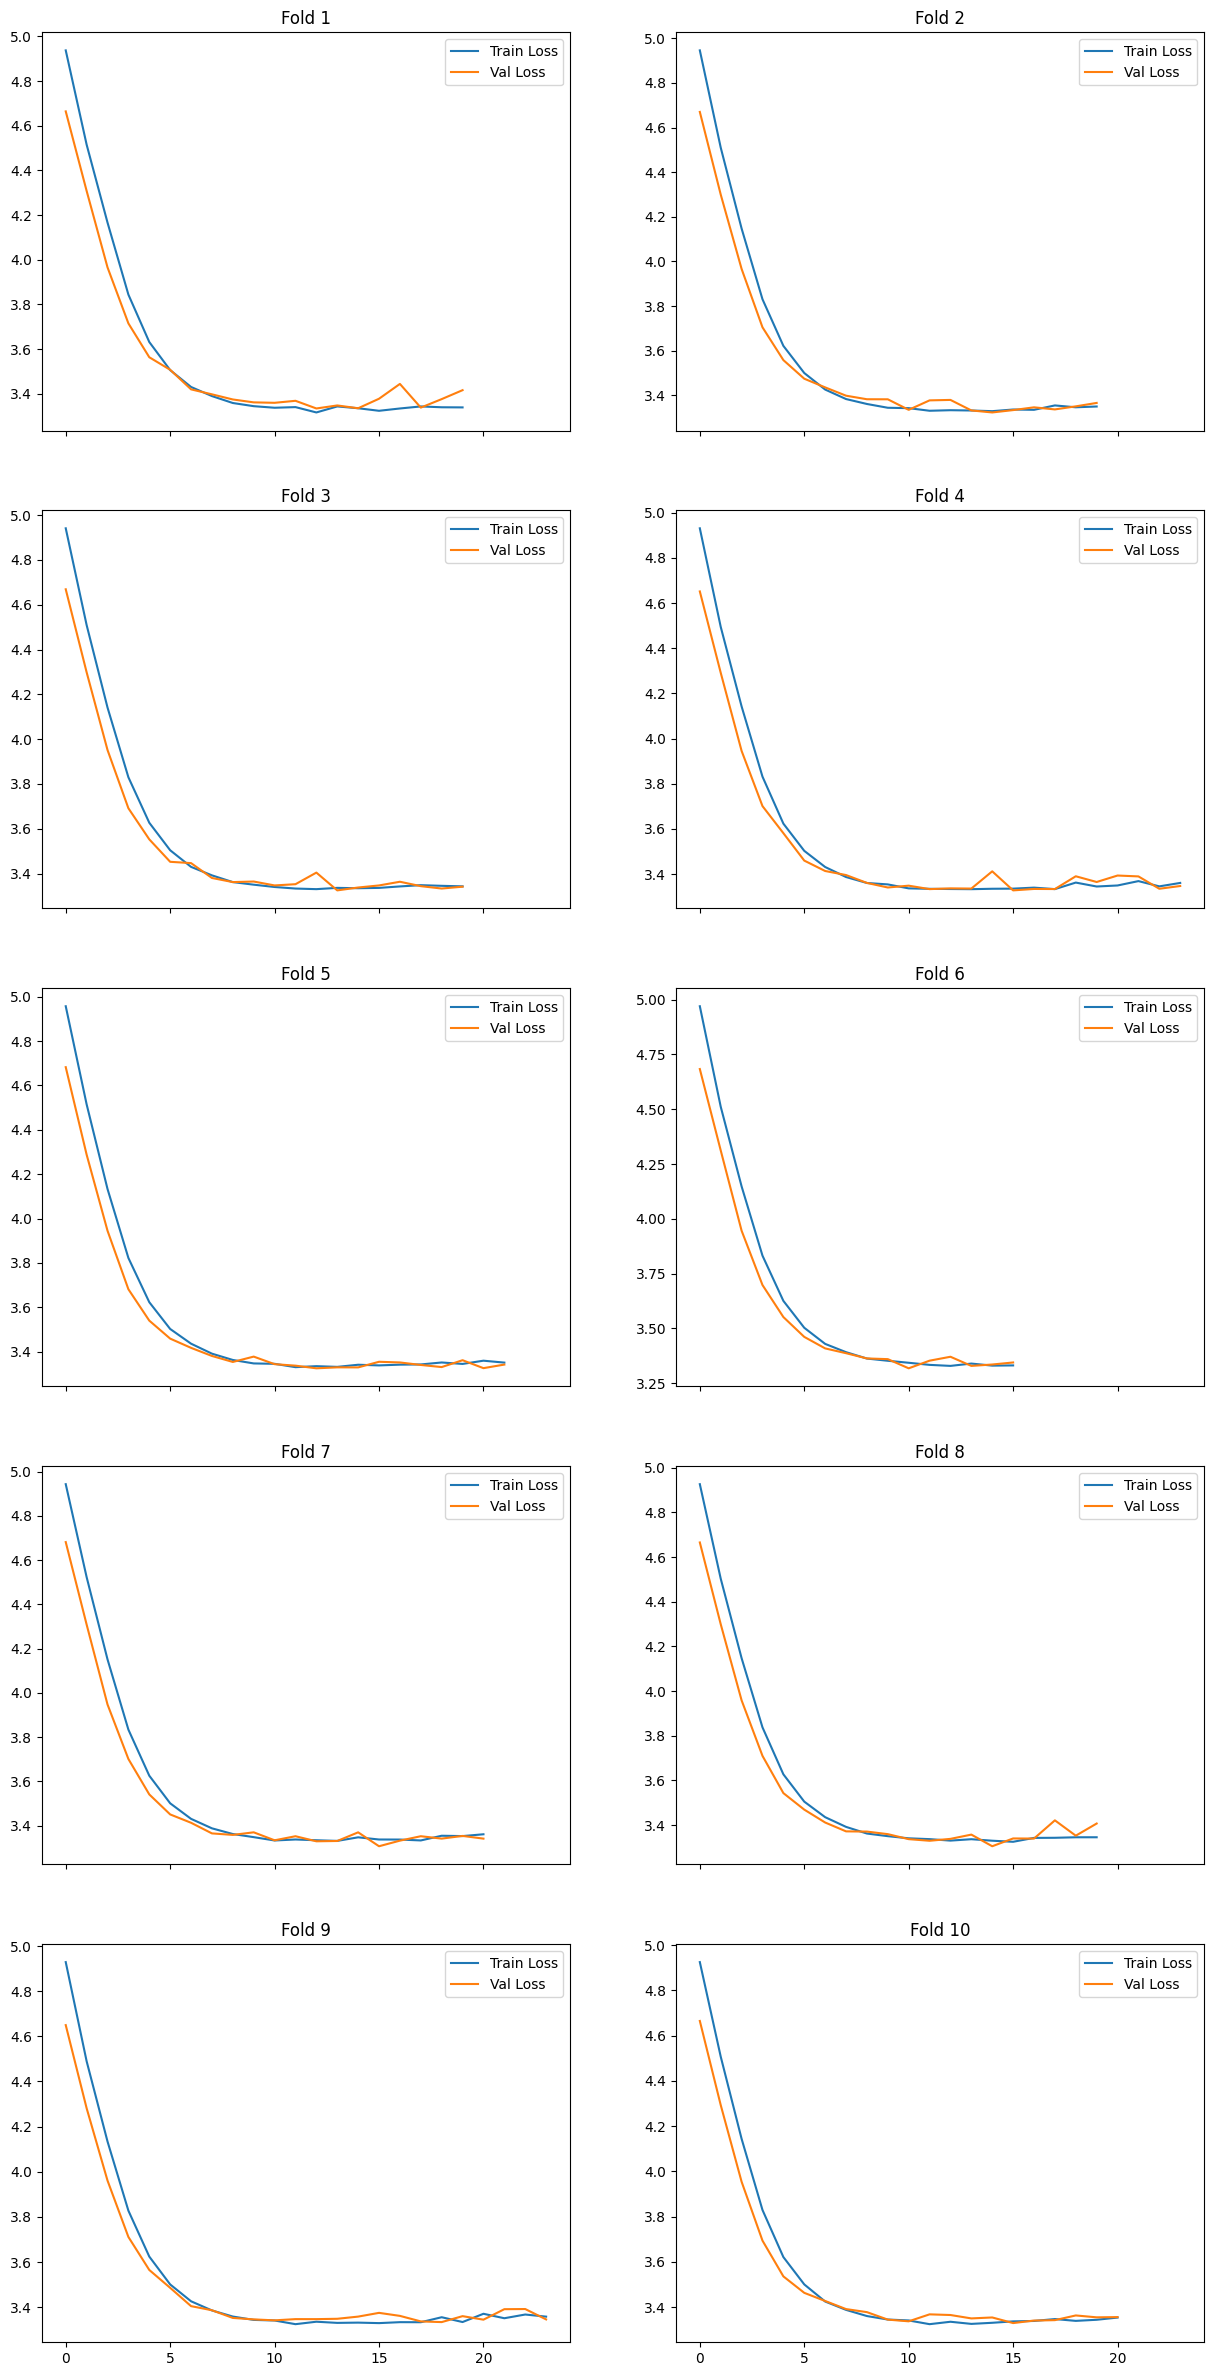

In [ ]:
# train-val loss plot
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(5, 2, sharex=True, figsize=(15, 30))

for i in range(5):
    sns.lineplot(x=range(len(complete_stats[splits[2*i]]["train"]["loss"])), y=complete_stats[splits[2*i]]["train"]["loss"], ax=ax[i][0], label="Train Loss")
    sns.lineplot(x=range(len(complete_stats[splits[2*i]]["val"]["loss"])), y=complete_stats[splits[2*i]]["val"]["loss"], ax=ax[i][0], label="Val Loss")
    sns.lineplot(x=range(len(complete_stats[splits[2*(i)+1]]["train"]["loss"])), y=complete_stats[splits[2*(i)+1]]["train"]["loss"], ax=ax[i][1], label="Train Loss")
    sns.lineplot(x=range(len(complete_stats[splits[2*(i)+1]]["val"]["loss"])), y=complete_stats[splits[2*(i)+1]]["val"]["loss"], ax=ax[i][1], label="Val Loss")
    ax[i][0].set_title(splits[2*i])
    ax[i][1].set_title(splits[2*(i)+1])
    
# plt.show()
loss_plot = plt.gcf()
loss_plot.savefig(f"./multi_feature_loss_{dataset}.png")

In [ ]:
file = open(f"./{dataset}_multi_feature_results.txt", "w")
file.write(f"{dataset} Results:\nAverage Train Acc: {max_train_acc}\nAverage Validation Acc: {max_val_acc}")
file.close()